Visualization, summer term 2024 \
\
Problem sheet 07

Submission by: 

Engel, Laurenz (21962216) \
Hesenkamp, Dennis (16442976) \
Multhaup, Justus (21963889)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy

# Exercise 7.1: dimensionality reduction on histograms, v2.

In [3]:
nPts = 10000
nBins = 100
bins=np.linspace(-4,4,num=nBins+1)
bincenters=0.5*(bins[1:]+bins[:-1])
S = np.array([0.8, 0.4, 0.2, 0.1])
mus = np.linspace(-1, 1, num=21)

def generate_histogram(std, mean):
    samples = np.random.normal(size=nPts)*std+mean
    hist = np.histogram(samples,bins=bins,density=True)[0]
    return hist



def generate_histograms(std):
    hist_list = []
    for mu in mus:
        hist = generate_histogram(std, mu)
        hist_list.append(hist)
    hist_list = np.array(hist_list)
    return hist_list

In [4]:
# compute lists for all values in S
data = []
for sigma in S:
    data.append(generate_histograms(sigma))
data = np.array(data)

In [5]:
# take PCA function from the lecture
def PCA(dataMat,keep=None,centered=False):
    nSamples,dim=dataMat.shape
    # centerted True, then data is already centered
    if not centered:
        mean=np.mean(dataMat,axis=0)
        dataMat=dataMat.copy()
        dataMat=dataMat-mean
    if dim<nSamples:
        if keep is None:
            keep=dim
        A=dataMat.transpose().dot(dataMat)/nSamples
        eigData=np.linalg.eigh(A)
        eigval=(eigData[0][-keep::])[::-1]
        eigvec=((eigData[1][:,-keep::]).transpose())[::-1]
    else:
        if keep is None:
            keep=nSamples
        A=dataMat.dot(dataMat.transpose())/nSamples
        eigData=np.linalg.eigh(A)
        eigval=(eigData[0][-keep::])[::-1]
        eigvec=((eigData[1][:,-keep::]).transpose())[::-1]

        eigvec=np.einsum(eigvec,[0,1],dataMat,[1,2],[0,2])
        # renormalize
        normList=np.linalg.norm(eigvec,axis=1)
        eigvec=np.einsum(eigvec,[0,1],1/normList,[0],[0,1])
    if not centered:
        return mean,eigval,eigvec
    else:
        return eigval,eigvec

In [6]:
means = []
eigvals = []
eigvecs = []
for hists in data:
    mean,eigval,eigvec=PCA(hists)
    means.append(mean)
    eigvals.append(eigval)
    eigvecs.append(eigvec)

eigvals = np.array(eigvals)
eigvecs = np.array(eigvecs)
means = np.array(means)

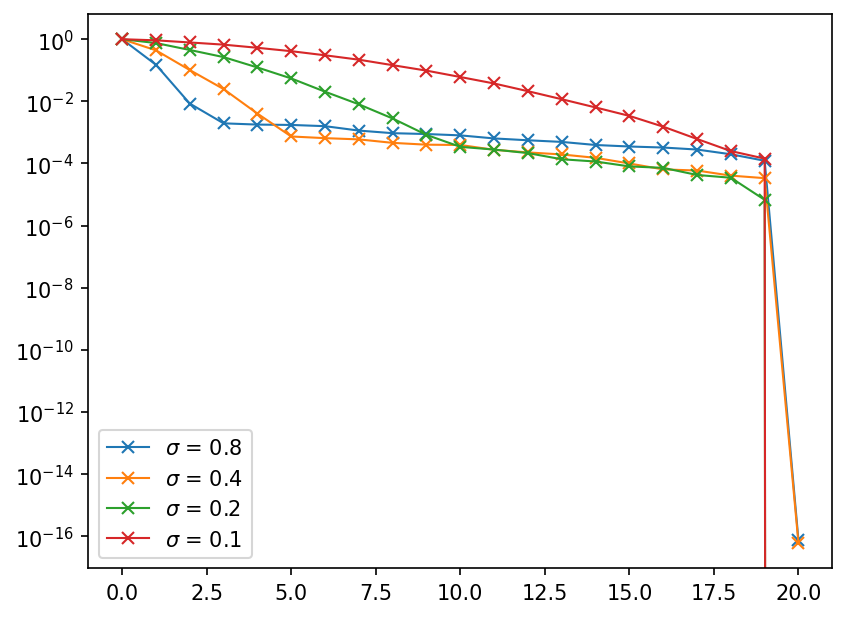

In [7]:
plt.figure(dpi=150)
for sigma, eigval in zip(S, eigvals):
    plt.plot(eigval/eigval[0], label=f"$\sigma$ = {sigma}", lw=1, marker="x")
    plt.yscale('log')
    plt.legend()
plt.show()

With increasing sigma, the dominant eigenvalues decrease faster. This means that the approximate dimension decreases for increasing sigma.

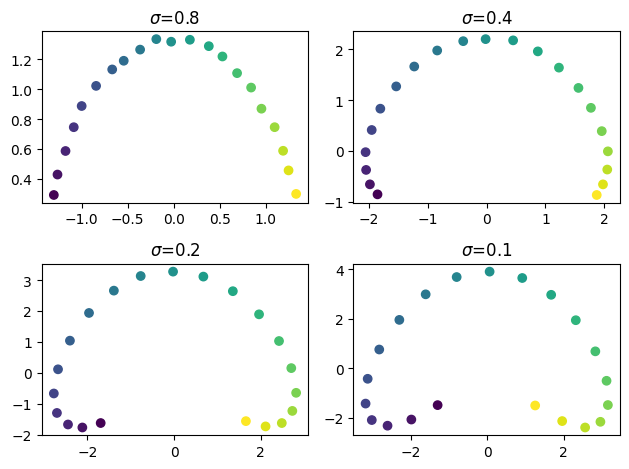

In [8]:
fig, axs = plt.subplots(2,2)
axs = axs.flatten()
for sigma, eigvec, hists, ax in zip(S, eigvecs, data, axs):
    # project data onto first two eigenvectors
    v1 = hists @ eigvec[0]
    v2 = hists @ eigvec[1]
    ax.scatter(v1, v2, c=mus)
    ax.set_title(f"$\sigma$={sigma}")
plt.tight_layout()
plt.show()

The points form a line, e.g. a 1D submanifold. You can clearly see that moving along the line corresponds to increasing the mean. For smaller sigma, this line 

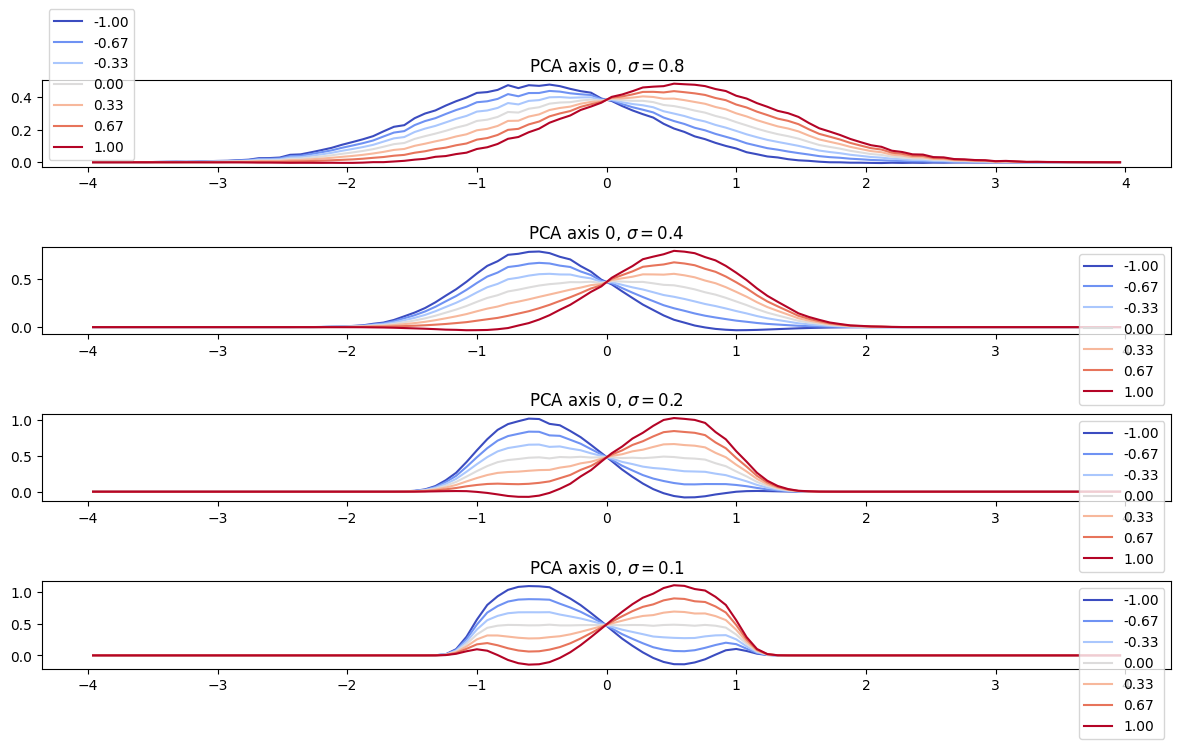

In [9]:
# define array for traversal along PCA direction
vals=np.linspace(-1,1,num=7)


fig=plt.figure(figsize=(12,7))
axs=fig.subplots(4)

for sigma, eigval, eigvec, mean, ax in zip(S, eigvals, eigvecs, means, axs):
    data_reverse=mean+(eigval[0]**0.5)*vals.reshape((-1,1))*eigvec[0].reshape((1,-1))
    for val,h in zip(vals,data_reverse):
        ax.plot(bincenters,h,c=matplotlib.cm.coolwarm((val+1)/2), label=f"{val:.2f}")
    ax.set_title(f"PCA axis {0}, $\sigma=${sigma}")
    ax.legend()

plt.tight_layout()
plt.show()

For large sigma, the traversal along the first PCA axis describes the mean shift very well. For smaller variances, it gets weird

# Exercise 7.2: embeddings with multidimensional scaling

In [33]:
n = 512
g1 = np.load('graph1.npz')
g2 = np.load('graph2.npz')

In [34]:
graph1 = scipy.sparse.coo_array((g1["data"], (g1["i"], g1["j"])), shape=(n, n)).toarray()
graph2 = scipy.sparse.coo_array((g2["data"], (g2["i"], g2["j"])), shape=(n, n)).toarray()

In [37]:
dist1 = scipy.sparse.csgraph.shortest_path(csgraph=graph1)**2
dist2 = scipy.sparse.csgraph.shortest_path(csgraph=graph2)**2

In [39]:
# functions from the lecture
def getGramMatrix(d2):
    """Recover gram matrix from squared distance matrix, this will be pos-definite
    if and only if distance matrix has Euclidean embedding."""
    d2Avg=np.mean(d2,axis=1)
    K=0.5*(d2Avg.reshape((-1,1))+d2Avg.reshape((1,-1))-d2)
    K-=np.mean(K)
    return K

def getMDSEmbedding(K):
    eigdat=np.linalg.eigh(K)
    eigval=eigdat[0][::-1]
    eigvec=eigdat[1].transpose()[::-1].copy()
    del eigdat
    y=np.einsum(eigvec,[0,1],np.maximum(0,eigval)**0.5,[0],[1,0])
    return eigval,eigvec,y


def plotMDSSpectrum(eigval):
    plt.title("spectrum of gram matrix")
    # show the spectrum, see if there are negative eigenvalues
    obj=plt.scatter(np.arange(len(eigval)),np.abs(eigval),c=np.sign(eigval),marker="x",lw=2,cmap="bwr")
    plt.colorbar(obj,boundaries=[-1.5,-0.5,0.5,1.5]).set_ticks([-1,0,1])
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

In [40]:
# compute gram matrices and embeddings
K1 = getGramMatrix(dist1)
eigval1, eigvec1, y1 = getMDSEmbedding(dist1)
K2 = getGramMatrix(dist1)
eigval2, eigvec2, y2 = getMDSEmbedding(dist2)

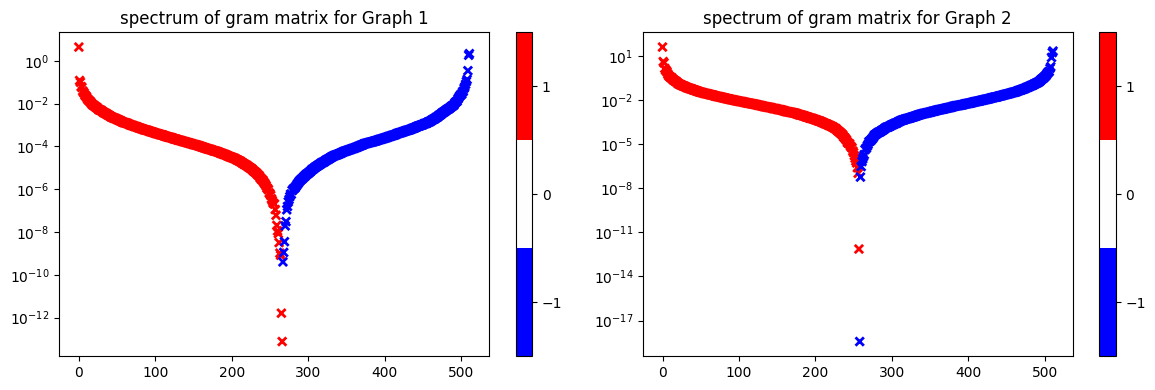

In [49]:
fig, axs = plt.subplots(1, 2, figsize = (12,4))
axs = axs.flatten()
axs[0].set_title("spectrum of gram matrix for Graph 1")
axs[1].set_title("spectrum of gram matrix for Graph 2")
# show the spectrum, see if there are negative eigenvalues
obj1=axs[0].scatter(np.arange(len(eigval1)),np.abs(eigval1),c=np.sign(eigval1),marker="x",lw=2,cmap="bwr")
axs[0].set_yscale("log")
plt.colorbar(obj1,boundaries=[-1.5,-0.5,0.5,1.5]).set_ticks([-1,0,1])
obj2=axs[1].scatter(np.arange(len(eigval2)),np.abs(eigval2),c=np.sign(eigval2),marker="x",lw=2,cmap="bwr")
axs[1].set_yscale("log")
plt.colorbar(obj2,boundaries=[-1.5,-0.5,0.5,1.5]).set_ticks([-1,0,1])
plt.tight_layout()
plt.show()

The computed graph distances are non-euclidian per construction, this is reflected in the spectrum since there are as many negative eigenvalues as positive ones. For a reasonable approximation, probably around 50-100 dimensions are needed.

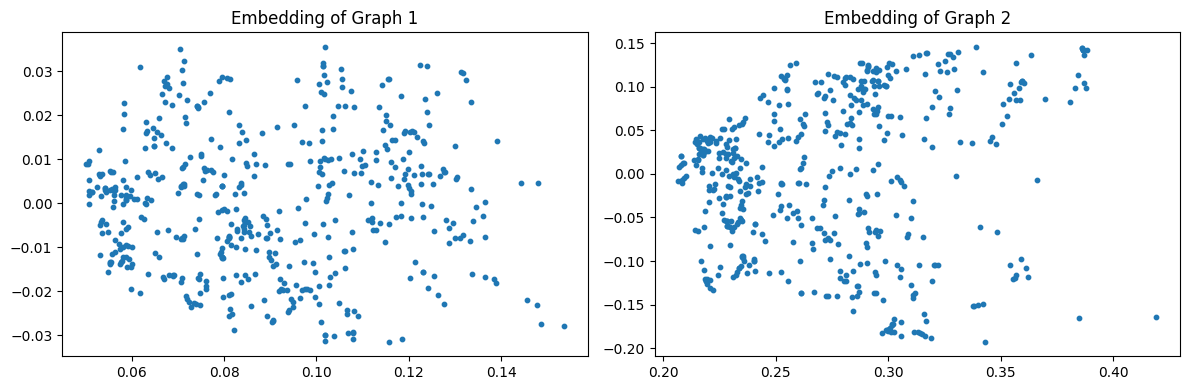

In [52]:

fig, axs = plt.subplots(1, 2, figsize = (12,4))
axs = axs.flatten()
axs[0].set_title("Embedding of Graph 1")
axs[1].set_title("Embedding of Graph 2")
# show the spectrum, see if there are negative eigenvalues
axs[0].scatter(y1[:,0],y1[:,1],s=10)
axs[1].scatter(y2[:,0],y2[:,1],s=10)

plt.tight_layout()
plt.show()